In [ ]:
import scanpy as sc
import numpy as np

read the data:

In [ ]:
adata = sc.datasets.pbmc3k()

/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [ ]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

some basic QC: find mitochondrial and ribosomal counts.

In [ ]:
adata.var['mito'] = adata.var.index.str.contains('^mt-', case=False)
rps = adata.var.index.str.contains('^RPS')
rpl = adata.var.index.str.contains('^RPL')
mrpl = adata.var.index.str.contains('^MRPL')
adata.var['ribo'] = rps | rpl | mrpl

In [ ]:
sc.pp.calculate_qc_metrics(adata,
                           inplace=True,
                           percent_top=[25],
                           qc_vars=['mito', 'ribo'])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


before proceeding, let's make a copy of the raw data so that we can get back to it if needed.

In [ ]:
adata.raw = adata.copy()

In [ ]:
adata.raw.X.sum(), adata.raw.X.max()

(6390631.0, 419.0)

now we can calculate neighbors/distances:

In [ ]:
sc.pp.neighbors(adata, use_rep='X')

In [ ]:
sc.tl.umap(adata)

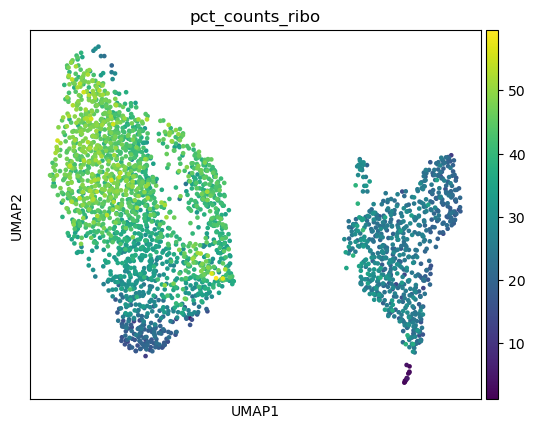

In [ ]:
sc.pl.umap(adata, color='pct_counts_ribo')

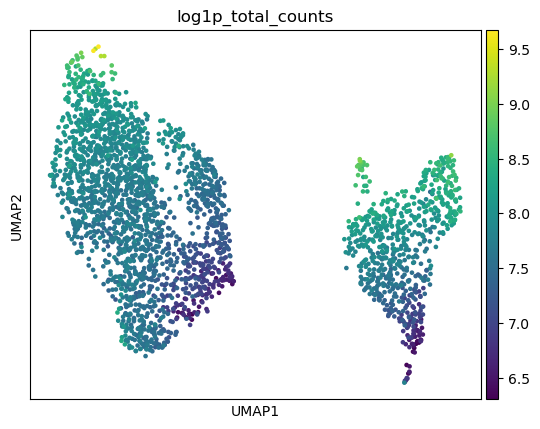

In [ ]:
sc.pl.umap(adata, color='log1p_total_counts')

## normalisation

we think the effect we see (gradient) is because of different "sizes"*; effectively, the bigger cells just have more genes be present, and in the distance calculations, those add up. If we normalize (i.e. pretend all cells are the same size), this effect should be alleviated.


\* "cell size" means the total number of transcripts.

In [ ]:
sc.pp.normalize_total(adata)

In [ ]:
adata.X.max(), adata.X.sum()

(384.70676, 5931900.5)

In [ ]:
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)

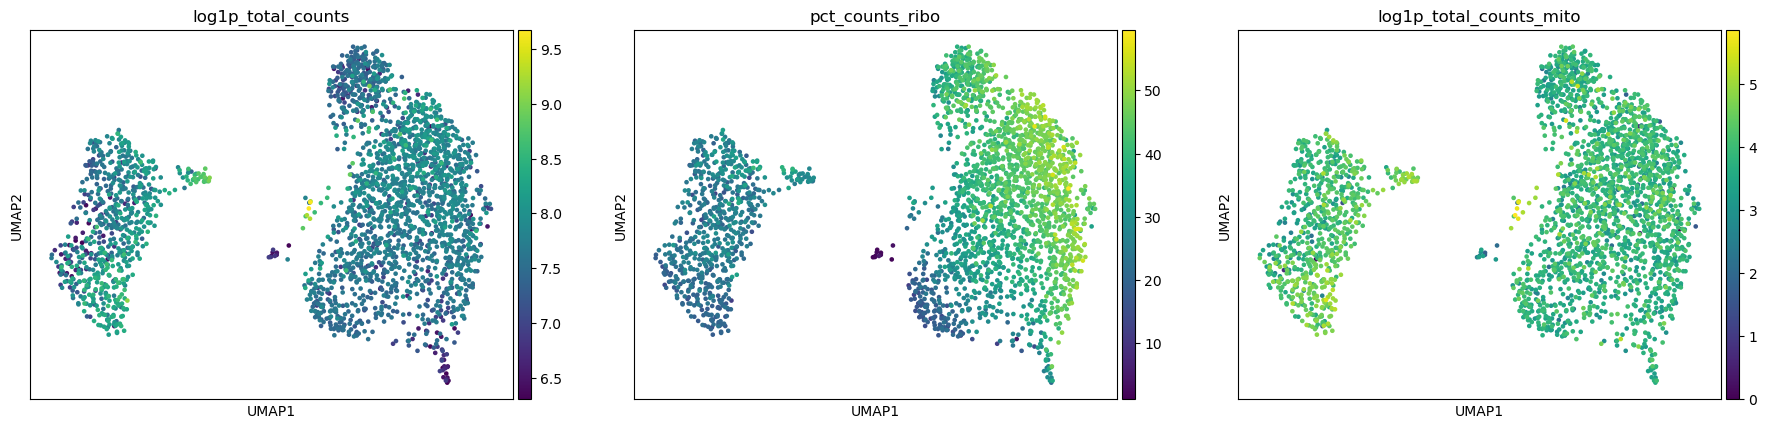

In [ ]:
sc.pl.umap(adata, color=['log1p_total_counts', 'pct_counts_ribo', 'log1p_total_counts_mito'])

Exploring the relationship between average expression and variance

In [ ]:
dense = adata.X.toarray()
adata.var['variance'] = np.var(dense, axis=0)

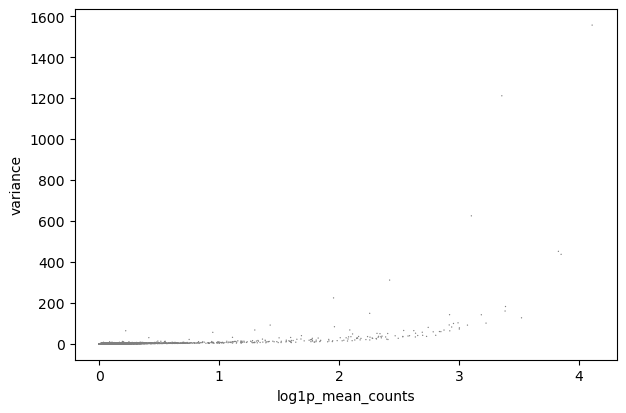

In [ ]:
sc.pl.scatter(adata, x='log1p_mean_counts', y='variance')

In [ ]:
import matplotlib.pyplot as plt

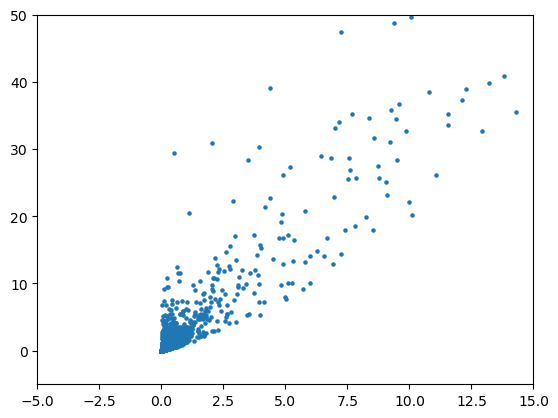

In [ ]:
fig, ax = plt.subplots()
ax.scatter(adata.var['mean_counts'], adata.var['variance'], s=5)
ax.set_xlim(-5, 15)
ax.set_ylim(-5, 50);

If the relationship between the variance and the mean is quadratic, doesn't that mean that taking the square root of the data would (somewhat) fix our issues? Let's try it out:

In [ ]:
adata.X = np.sqrt(adata.X)

In [ ]:
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)

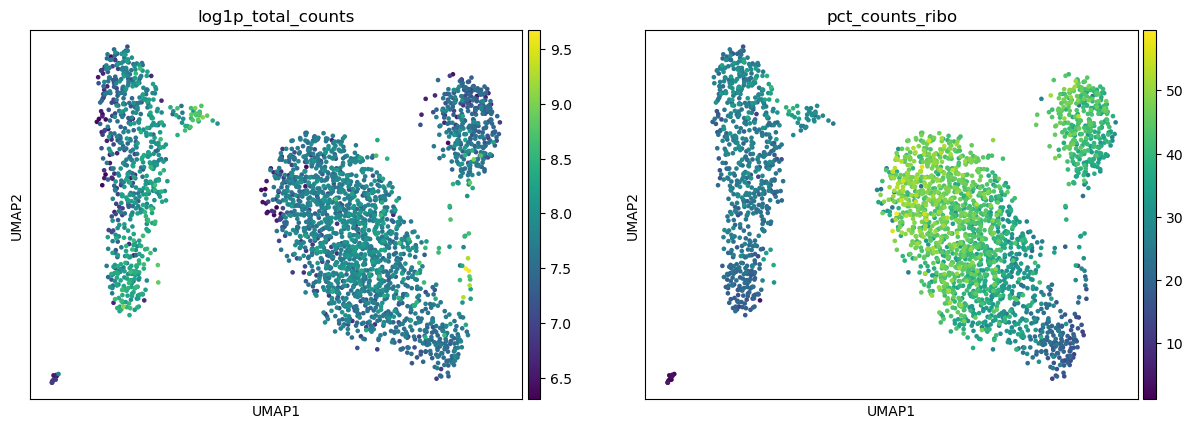

In [ ]:
sc.pl.umap(adata, color=['log1p_total_counts', 'pct_counts_ribo'])

Let's be a bit more organized about this:

...but first, make sure that the raw counts are still actually raw:

In [ ]:
adata.raw.X.max(), adata.raw.X.sum()

(419.0, 6390631.0)

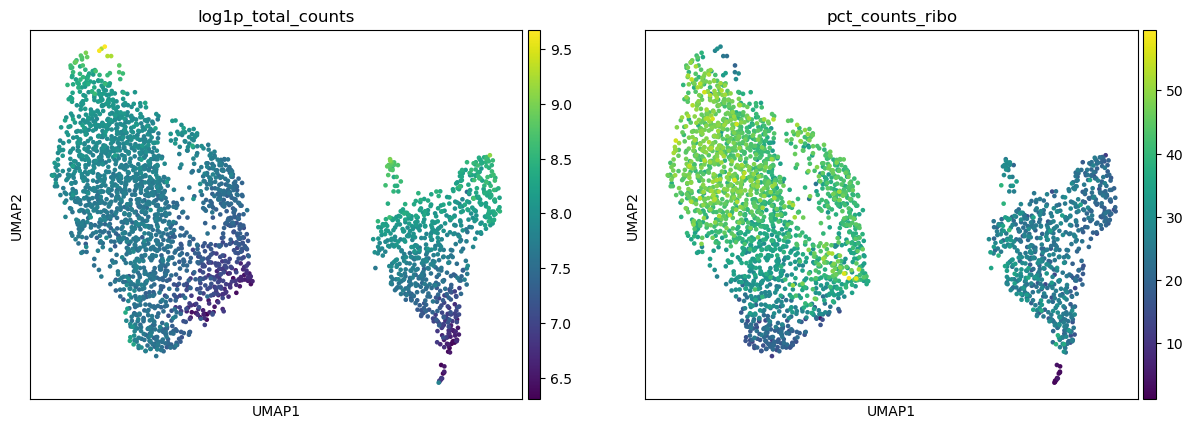

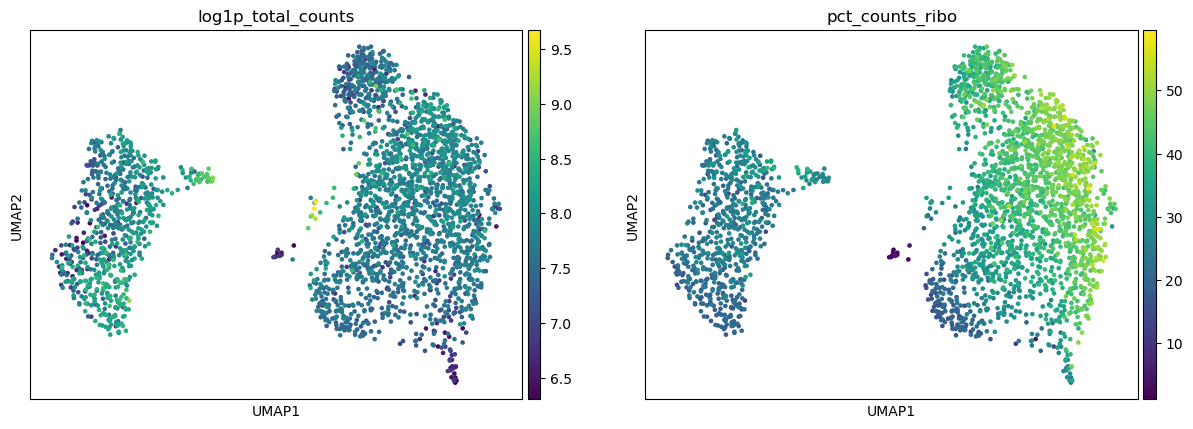

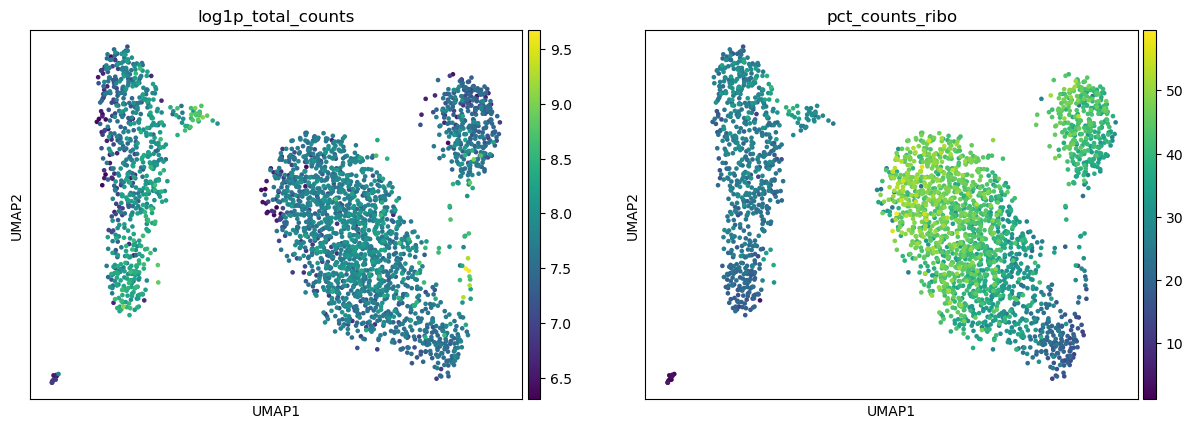

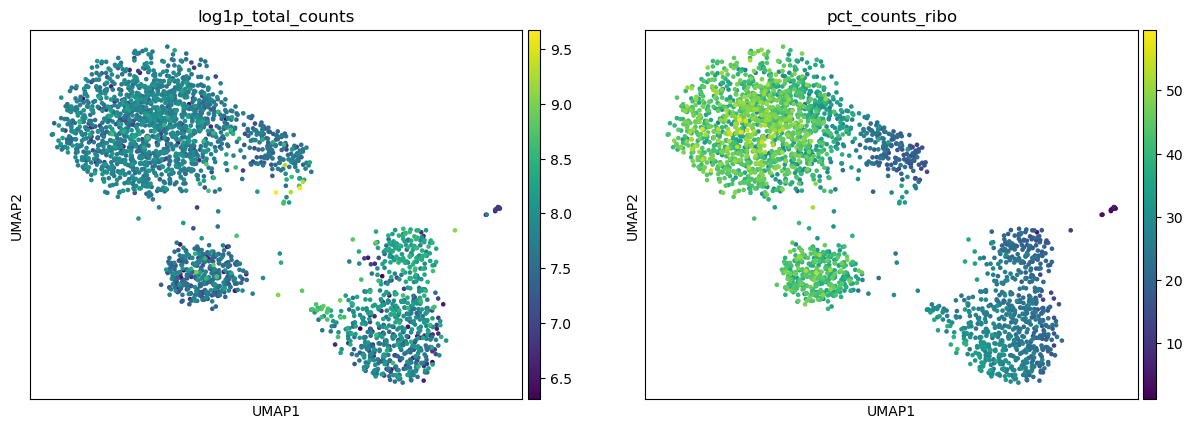

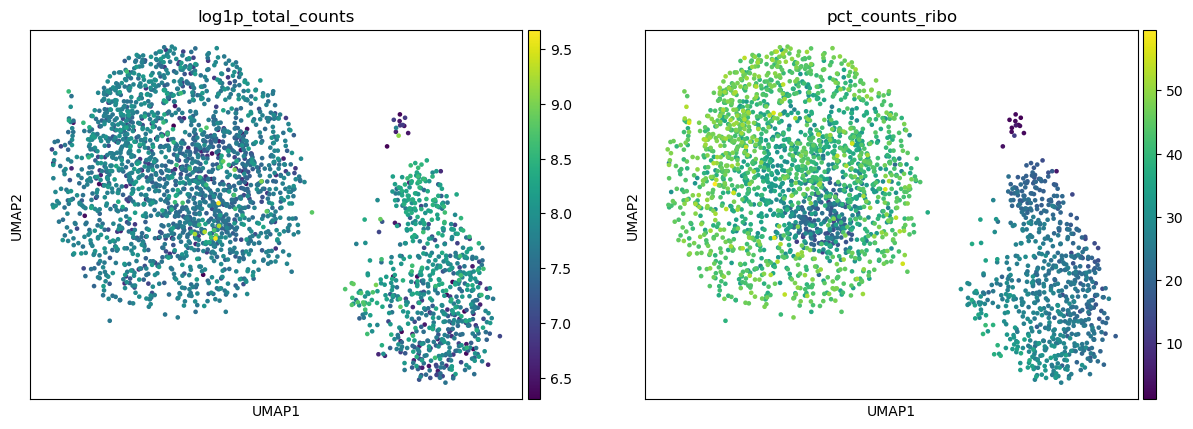

In [ ]:
# first, just raw counts
# reset counts
adata.X = adata.raw.X.copy()
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['log1p_total_counts', 'pct_counts_ribo'])

# just normalise:
adata.X = adata.raw.X.copy()
sc.pp.normalize_total(adata)
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['log1p_total_counts', 'pct_counts_ribo'])

# normalise, then square root transform:
adata.X = adata.raw.X.copy()
sc.pp.normalize_total(adata)
adata.X = np.sqrt(adata.X)
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['log1p_total_counts', 'pct_counts_ribo'])

# normalise, then log1p-transform:
adata.X = adata.raw.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['log1p_total_counts', 'pct_counts_ribo'])

# extra fancy: normalise, then log1p-transform, then normalise _again_:
adata.X = adata.raw.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.normalize_total(adata)
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['log1p_total_counts', 'pct_counts_ribo'])

and the winner is... square root transformt

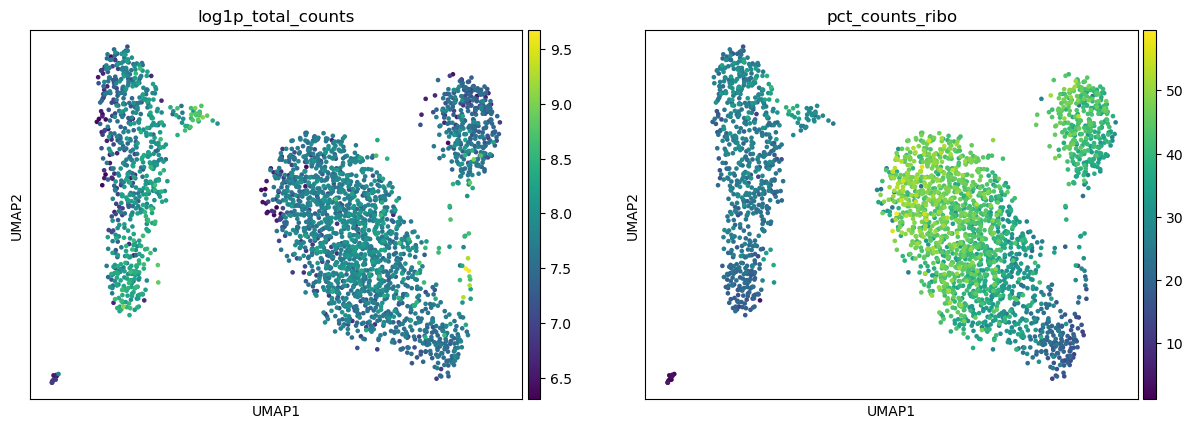

In [ ]:
adata.X = adata.raw.X.copy()
sc.pp.normalize_total(adata)
adata.X = np.sqrt(adata.X)
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['log1p_total_counts', 'pct_counts_ribo'])

In [ ]:
sc.tl.leiden(adata, resolution=50)

/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


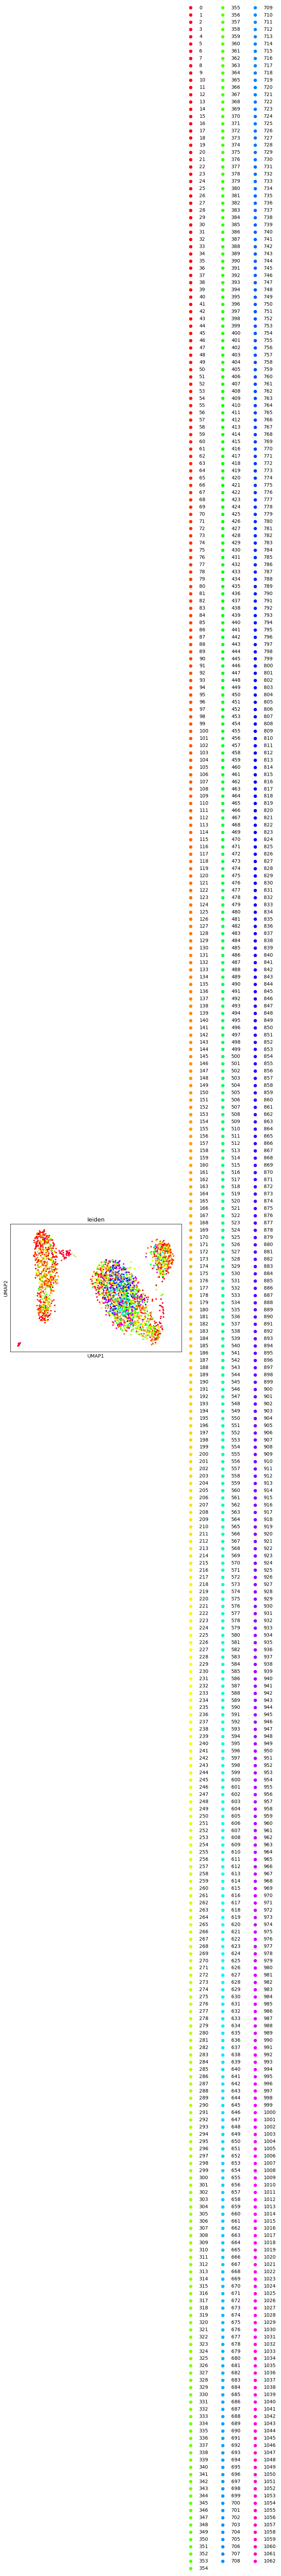

In [ ]:
sc.pl.umap(adata, color='leiden', palette='gist_rainbow')